Read sections 3.3.1 and 3.3.2 of the book before using these notes.

Note: these notes focus on implementation. The book provides the conceptual explanations.


In [23]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

sns.set_theme(style="whitegrid", font_scale=1.2)

## Learning objectives

By the end of this notebook you should be able to:

- Add and interpret interaction terms in linear regression models.
- Incorporate qualitative predictors and understand baseline-level encoding.
- Model interactions between qualitative and continuous predictors.
- Apply polynomial transformations to capture non-linear relationships.
- Use `PolynomialFeatures` in `sklearn` to generate polynomial terms and interactions.


## Dataset

- Training set: `Datasets/Car_features_train.csv`, `Datasets/Car_prices_train.csv`
- Test set: `Datasets/Car_features_test.csv`, `Datasets/Car_prices_test.csv`

We replace `year` with `age`, computed as `reference_year - year`, where `reference_year` is the most recent model year in the training data.


In [3]:
# Read data
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')

train = pd.merge(trainf, trainp)
test = pd.merge(testf, testp)

# Create age feature using the most recent model year in the training data
reference_year = train["year"].max()
train["age"] = reference_year - train["year"]
test["age"] = reference_year - test["year"]

train.head()


,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price,age
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980,0
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980,1
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850,0
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998,3
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990,5


## statsmodels (formula API)


### Interaction terms (continuous predictors)

We relax the constant-association assumption by adding an interaction between `engineSize` and `age`.


In [4]:
# Interaction between engineSize and age
model_sm_interaction = smf.ols(
    formula='price ~ age*engineSize + mileage + mpg',
    data=train,
).fit()

model_sm_interaction.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     2121.
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:55:41   Log-Likelihood:                -52338.
No. Observations:                4960   AIC:                         1.047e+05
Df Residuals:                    4954   BIC:                         1.047e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4313.7409    804.871      5.360      0.000    2735.838    5891.644
age              275.3833    135.695      2.029      0.042       9.361     541.405
engineSize       1.52e+04    248.298     61.231      0.000    1.47e+04    1.57e+04
age:engineSize  -896.7687     49.431    -18.142      0.000    -993.676    -799.861
mileage           -0.1525      0.008    -17.954      0.000      -0.169      -0.136
mpg              -84.3417      9.048     -9.322      0.000    -102.079     -66.604
==============================================================================
Omnibus:                     2330.413   Durbin-Watson:                   0.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29977.437
Skew:                           1.908   Prob(JB):                         0.00
Kurtosis:                      14.423   Cond. No.                     2.22e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model equation is:

\begin{equation}
price = \beta_0 + \beta_1*age + \beta_2*engineSize + \beta_3*(age * engineSize) + \beta_4*mileage + \beta_5*mpg
\end{equation}

The effect of `engineSize` on price now depends on `age`, and the effect of `age` depends on `engineSize`.


In [5]:
# RMSE on test data
pred_price = model_sm_interaction.predict(test)
np.sqrt(((test.price - pred_price) ** 2).mean())


9423.598872488523

Interaction terms add flexibility to the model, which can improve fit but may also increase the risk of overfitting.


### Qualitative predictors

Develop a model for predicting `price` based on `engineSize` and the qualitative predictor `transmission`.


In [6]:
# Check the distribution of transmission values
train.transmission.value_counts()


transmission
Manual       1948
Automatic    1660
Semi-Auto    1351
Other           1
Name: count, dtype: int64

The *Other* category has very few observations. We remove it here (another option is to combine it with a nearby category).


In [7]:
train_updated = train[train.transmission != 'Other']


In [8]:
model_sm_trans = smf.ols(
    formula='price ~ engineSize + transmission',
    data=train_updated,
).fit()

model_sm_trans.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     1400.
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:56:19   Log-Likelihood:                -53644.
No. Observations:                4959   AIC:                         1.073e+05
Df Residuals:                    4955   BIC:                         1.073e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  3042.6765    661.190      4.602      0.000    1746.451    4338.902
transmission[T.Manual]    -6770.6165    442.116    -15.314      0.000   -7637.360   -5903.873
transmission[T.Semi-Auto]  4994.3112    442.989     11.274      0.000    4125.857    5862.765
engineSize                 1.023e+04    247.485     41.323      0.000    9741.581    1.07e+04
==============================================================================
Omnibus:                     1575.518   Durbin-Watson:                   0.579
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11006.609
Skew:                           1.334   Prob(JB):                         0.00
Kurtosis:                       9.793   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The baseline level is dropped by default (alphabetical order). Here, *Automatic* is the baseline. Coefficients for other levels are interpreted relative to the baseline.


**Q:** Interpret the intercept term.

**A:** For a hypothetical car with zero engine size and *Automatic* transmission, the estimated mean price is the intercept.


**Q:** Interpret the coefficient of `transmission[T.Manual]`.

**A:** Holding engine size fixed, the estimated mean price of a manual car differs from an automatic car by that coefficient.


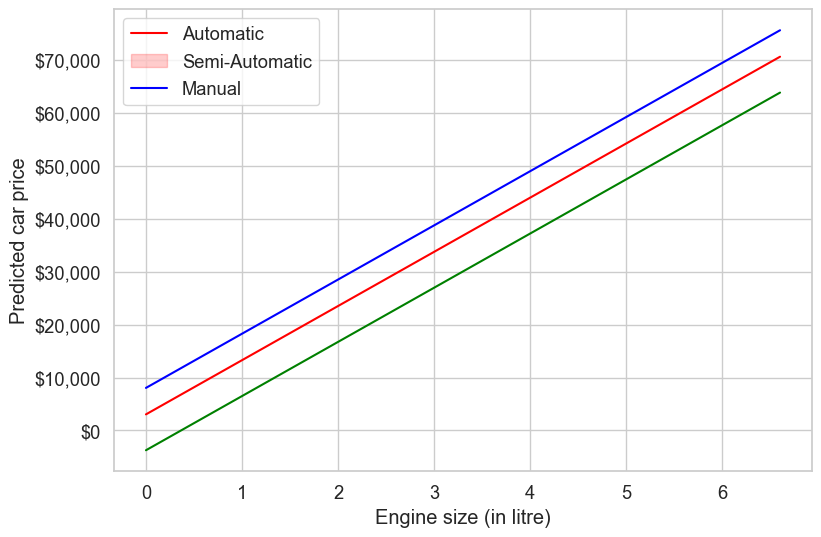

In [9]:
# Visualize the model
plt.rcParams["figure.figsize"] = (9, 6)
x = np.linspace(train_updated.engineSize.min(), train_updated.engineSize.max(), 100)
ax = sns.lineplot(x=x, y=model_sm_trans.params['engineSize']*x + model_sm_trans.params['Intercept'], color='red')
sns.lineplot(x=x, y=model_sm_trans.params['engineSize']*x + model_sm_trans.params['Intercept'] + model_sm_trans.params['transmission[T.Semi-Auto]'], color='blue')
sns.lineplot(x=x, y=model_sm_trans.params['engineSize']*x + model_sm_trans.params['Intercept'] + model_sm_trans.params['transmission[T.Manual]'], color='green')
plt.legend(labels=["Automatic", "Semi-Automatic", "Manual"])
plt.xlabel('Engine size (in litre)')
plt.ylabel('Predicted car price')
ax.yaxis.set_major_formatter('${x:,.0f}')


### Interaction between qualitative and continuous predictors

The parallel lines above assume the effect of engine size is the same for each transmission type. We can relax that by adding an interaction between `engineSize` and `transmission`.


In [10]:
model_sm_trans_inter = smf.ols(
    formula='price ~ engineSize*transmission',
    data=train_updated,
).fit()

model_sm_trans_inter.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     909.9
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:57:06   Log-Likelihood:                -53550.
No. Observations:                4959   AIC:                         1.071e+05
Df Residuals:                    4953   BIC:                         1.072e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             3754.7238    895.221      4.194      0.000    1999.695    5509.753
transmission[T.Manual]                1768.5856   1294.071      1.367      0.172    -768.366    4305.538
transmission[T.Semi-Auto]            -5282.7164   1416.472     -3.729      0.000   -8059.628   -2505.805
engineSize                            9928.6082    354.511     28.006      0.000    9233.610    1.06e+04
engineSize:transmission[T.Manual]    -5285.9059    646.175     -8.180      0.000   -6552.695   -4019.117
engineSize:transmission[T.Semi-Auto]  4162.2428    552.597      7.532      0.000    3078.908    5245.578
==============================================================================
Omnibus:                     1379.846   Durbin-Watson:                   0.622
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9799.471
Skew:                           1.139   Prob(JB):                         0.00
Kurtosis:                       9.499   Cond. No.                         30.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Q:** Interpret the coefficient of `transmission[T.Manual]`.

**A:** It shifts the intercept for manual cars relative to automatic cars.

**Q:** Interpret the coefficient of `engineSize:transmission[T.Manual]`.

**A:** It adjusts the slope of engine size for manual cars relative to automatic cars.


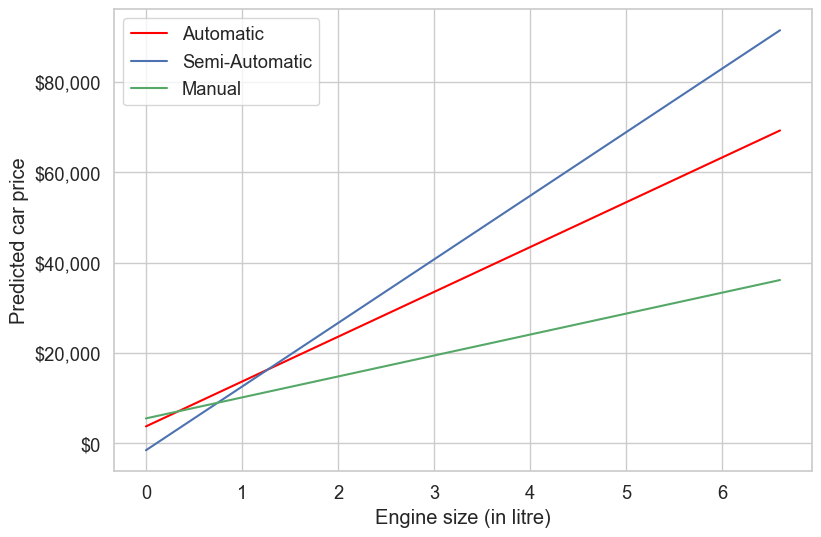

In [11]:
# Visualize the model with interaction terms
plt.rcParams["figure.figsize"] = (9, 6)
x = np.linspace(train_updated.engineSize.min(), train_updated.engineSize.max(), 100)
ax = sns.lineplot(x=x, y=model_sm_trans_inter.params['engineSize']*x + model_sm_trans_inter.params['Intercept'], label='Automatic', color='red')
plt.plot(
    x,
    (model_sm_trans_inter.params['engineSize'] + model_sm_trans_inter.params['engineSize:transmission[T.Semi-Auto]'])*x
    + model_sm_trans_inter.params['Intercept']
    + model_sm_trans_inter.params['transmission[T.Semi-Auto]'],
    '-b',
    label='Semi-Automatic'
)
plt.plot(
    x,
    (model_sm_trans_inter.params['engineSize'] + model_sm_trans_inter.params['engineSize:transmission[T.Manual]'])*x
    + model_sm_trans_inter.params['Intercept']
    + model_sm_trans_inter.params['transmission[T.Manual]'],
    '-g',
    label='Manual'
)
plt.legend(loc='upper left')
plt.xlabel('Engine size (in litre)')
plt.ylabel('Predicted car price')
ax.yaxis.set_major_formatter('${x:,.0f}')


### Polynomial transformations

So far we assumed linear relationships. If the relationship between `price` and `mileage` is curved, polynomial terms can help.


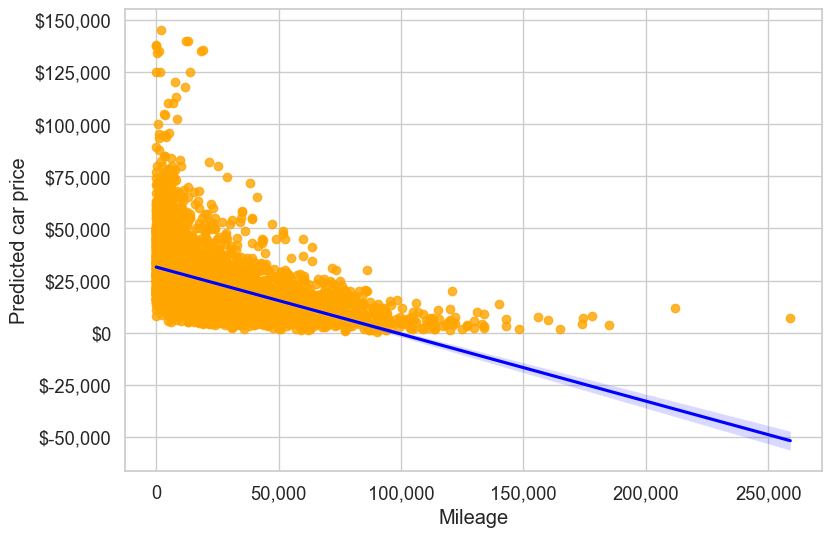

In [12]:
# Relationship between price and mileage
ax = sns.regplot(x=train_updated.mileage, y=train_updated.price, color='orange', line_kws={'color': 'blue'})
plt.xlabel('Mileage')
plt.ylabel('Predicted car price')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_formatter('{x:,.0f}')


In [13]:
# R-squared of the model with just mileage
model_sm_mileage = smf.ols('price ~ mileage', data=train_updated).fit()
model_sm_mileage.rsquared


0.22928048993376182

#### Quadratic transformation

Add a squared term for `mileage` using the `I()` operator to keep it as a separate predictor.


In [14]:
model_sm_quad = smf.ols('price ~ mileage + I(mileage**2)', data=train_updated).fit()
model_sm_quad.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     920.6
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:57:58   Log-Likelihood:                -54382.
No. Observations:                4959   AIC:                         1.088e+05
Df Residuals:                    4956   BIC:                         1.088e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         3.44e+04    332.710    103.382      0.000    3.37e+04     3.5e+04
mileage            -0.5662      0.017    -33.940      0.000      -0.599      -0.534
I(mileage ** 2)  2.629e-06   1.56e-07     16.813      0.000    2.32e-06    2.94e-06
==============================================================================
Omnibus:                     2362.973   Durbin-Watson:                   0.325
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22427.952
Skew:                           2.052   Prob(JB):                         0.00
Kurtosis:                      12.576   Cond. No.                     4.81e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

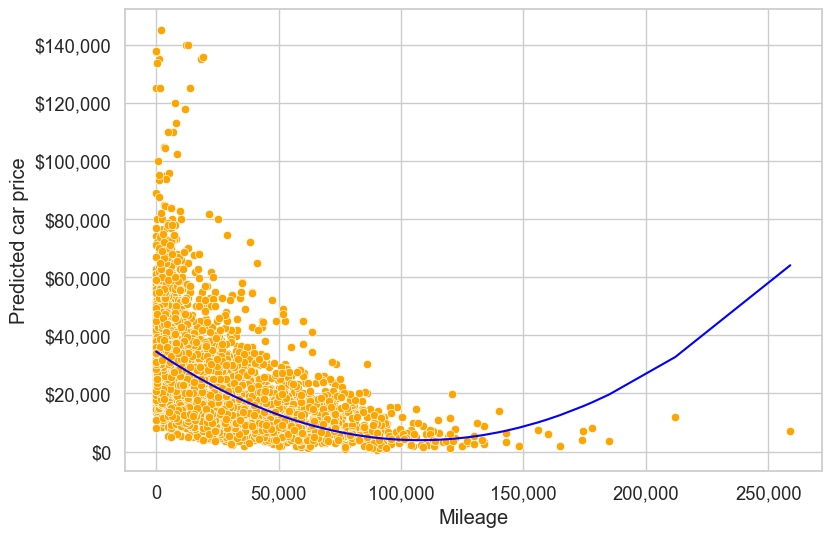

In [15]:
# Visualize the quadratic fit
pred_price = model_sm_quad.predict(train_updated)
ax = sns.scatterplot(x='mileage', y='price', data=train_updated, color='orange')
sns.lineplot(x=train_updated.mileage, y=pred_price, color='blue')
plt.xlabel('Mileage')
plt.ylabel('Predicted car price')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_formatter('{x:,.0f}')


#### Cubic transformation

Add a cubic term for additional flexibility.


In [16]:
model_sm_cubic = smf.ols('price ~ mileage + I(mileage**2) + I(mileage**3)', data=train_updated).fit()
model_sm_cubic.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     652.3
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:58:10   Log-Likelihood:                -54340.
No. Observations:                4959   AIC:                         1.087e+05
Df Residuals:                    4955   BIC:                         1.087e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.598e+04    371.925     96.728      0.000    3.52e+04    3.67e+04
mileage            -0.7742      0.028    -27.634      0.000      -0.829      -0.719
I(mileage ** 2)  6.875e-06   4.87e-07     14.119      0.000    5.92e-06    7.83e-06
I(mileage ** 3) -1.823e-11   1.98e-12     -9.199      0.000   -2.21e-11   -1.43e-11
==============================================================================
Omnibus:                     2380.789   Durbin-Watson:                   0.321
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23039.334
Skew:                           2.065   Prob(JB):                         0.00
Kurtosis:                      12.719   Cond. No.                     7.73e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.73e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

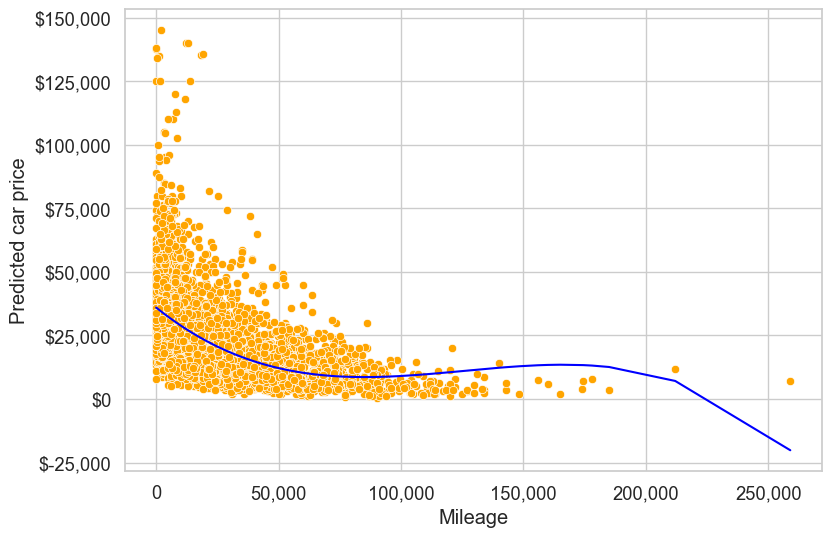

In [17]:
# Visualize the cubic fit
pred_price = model_sm_cubic.predict(train_updated)
ax = sns.scatterplot(x='mileage', y='price', data=train_updated, color='orange')
sns.lineplot(x=train_updated.mileage, y=pred_price, color='blue')
plt.xlabel('Mileage')
plt.ylabel('Predicted car price')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_formatter('{x:,.0f}')


#### Putting interaction and transformation together

Combine the interaction term with a quadratic mileage term.


In [18]:
model_sm_full = smf.ols(
    formula='price ~ age*engineSize + mileage + mpg + I(mileage**2)',
    data=train_updated,
).fit()

model_sm_full.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     1947.
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:58:23   Log-Likelihood:                -52162.
No. Observations:                4959   AIC:                         1.043e+05
Df Residuals:                    4952   BIC:                         1.044e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3853.3738    779.161      4.946      0.000    2325.873    5380.875
age               755.7419    133.791      5.649      0.000     493.453    1018.031
engineSize       1.565e+04    241.430     64.811      0.000    1.52e+04    1.61e+04
age:engineSize  -1008.6993     48.196    -20.929      0.000   -1103.184    -914.215
mileage            -0.3548      0.014    -25.973      0.000      -0.382      -0.328
mpg               -54.7450      8.896     -6.154      0.000     -72.185     -37.305
I(mileage ** 2)  1.926e-06   1.04e-07     18.536      0.000    1.72e-06    2.13e-06
==============================================================================
Omnibus:                     2355.448   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38317.406
Skew:                           1.857   Prob(JB):                         0.00
Kurtosis:                      16.101   Cond. No.                     1.83e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.83e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
# RMSE on test data
pred_price = model_sm_full.predict(test)
np.sqrt(((test.price - pred_price) ** 2).mean())


9074.49407060908

## sklearn ([`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html))

`PolynomialFeatures` generates polynomial terms and interactions automatically. We then fit a linear regression on the expanded feature set.


In [20]:
X_train = train[['mileage', 'engineSize', 'age', 'mpg']]
y_train = train['price']
X_test = test[['mileage', 'engineSize', 'age', 'mpg']]
y_test = test['price']


In [21]:
# Generate polynomial features up to degree 2
poly = PolynomialFeatures(2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


In [22]:
# Fit the model
model_skl = LinearRegression()
model_skl.fit(X_train_poly, y_train)


LinearRegression()

In [24]:
# Predict on test data
pred_price = model_skl.predict(X_test_poly)

# RMSE on test data
rmse = root_mean_squared_error(y_test, pred_price)
mae = mean_absolute_error(y_test, pred_price)
print(f'Sklearn Linear Regression Test RMSE: ${rmse:,.2f}')
print(f'Sklearn Linear Regression Test MAE: ${mae:,.2f}')

# r2 score
r2 = r2_score(y_test, pred_price)
print(f'Sklearn Linear Regression Test R²: {r2:.4f}')


Sklearn Linear Regression Test RMSE: $8,896.17
Sklearn Linear Regression Test MAE: $5,335.30
Sklearn Linear Regression Test R²: 0.7127


By default, `PolynomialFeatures` uses `degree=2` and `interaction_only=False`, which includes both squared terms and pairwise interactions. If we set `interaction_only=True`, the design matrix includes only interaction terms (no squared terms). Let's compare performance.


In [27]:
# Interaction-only polynomial features (degree 2)
poly_inter = PolynomialFeatures(2, include_bias=False, interaction_only=True)
X_train_inter = poly_inter.fit_transform(X_train)
X_test_inter = poly_inter.transform(X_test)

model_inter = LinearRegression()
model_inter.fit(X_train_inter, y_train)

pred_price_inter = model_inter.predict(X_test_inter)
rmse_inter = root_mean_squared_error(y_test, pred_price_inter)
mae_inter = mean_absolute_error(y_test, pred_price_inter)
r2_inter = r2_score(y_test, pred_price_inter)

print(f'Interaction-only Test RMSE: ${rmse_inter:,.2f}')
print(f'Interaction-only Test MAE: ${mae_inter:,.2f}')
print(f'Interaction-only Test R2: {r2_inter:.4f}')


Interaction-only Test RMSE: $8,729.91
Interaction-only Test MAE: $5,400.07
Interaction-only Test R2: 0.7234


Compare the two settings side by side.


In [32]:
comparison = pd.DataFrame(
    {
        "Model": ["Full poly (degree=2)", "Interaction-only (degree=2)"],
        "RMSE": [rmse, rmse_inter],
        "MAE": [mae, mae_inter],
        "R2": [r2, r2_inter],
    }
)
comparison



,Model,RMSE,MAE,R2
0,Full poly (degree=2),8896.171003,5335.298018,0.712714
1,Interaction-only (degree=2),8729.912067,5400.071918,0.723352


In [33]:

# Compare feature names
features_full = pd.Series(poly.get_feature_names_out(input_features=X_train.columns), name="Full poly")
features_inter = pd.Series(poly_inter.get_feature_names_out(input_features=X_train.columns), name="Interaction-only")

feature_compare = pd.concat([features_full, features_inter], axis=1)
feature_compare

,Full poly,Interaction-only
0,mileage,mileage
1,engineSize,engineSize
2,age,age
3,mpg,mpg
4,mileage^2,mileage engineSize
5,mileage engineSize,mileage age
6,mileage age,mileage mpg
7,mileage mpg,engineSize age
8,engineSize^2,engineSize mpg
9,engineSize age,age mpg


A key limitation of `PolynomialFeatures` is that it lacks the flexibility of `statsmodels`. With `statsmodels`, you can selectively add specific interaction and polynomial terms. With `PolynomialFeatures`, you either include all polynomial and interaction terms of a given degree or none at all.

Despite this limitation, `PolynomialFeatures` is quite useful for quickly generating polynomial and interaction terms. We will explore it further in the next lab.